In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re

**Load the dataset and then only used the paper_text column for text generation**

In [2]:
data = pd.read_csv('../input/all-trumps-twitter-insults-20152021/trump_insult_tweets_2014_to_2021.csv')
data.head()

,Unnamed: 0,date,target,insult,tweet
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily..."


In [3]:
tweets = data['tweet'].copy()
del data

**Added three new tokens in the pre-trained GPT2 tokenizer: \**

**<|sos|> : start of sentence \**

**<|eos|> : end of sentence \**

**<|pad|> : padding token****

In [4]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|sos|>', 
                                          eos_token='<|eos|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

In [5]:
max_tweet = max([len(tokenizer.encode(tweet)) for tweet in tweets])

print(f'The longest text is {max_tweet} tokens long.')

The longest text is 108 tokens long.


**Next we create a custom dataloader for our tweet using torch Dataset. \
Each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask**

In [6]:
batch_size = 32

import torch
#torch.cuda.empty_cache()
from torch.utils.data import Dataset

class PaperDataset(Dataset):
    def __init__(self,tweets,tokenizer,gpt2_type="gpt2",max_length=max_tweet):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_masks = []
        
        for tweet in tweets:
            encoding_dict = tokenizer('<|sos|>'+ tweet +'<|eos|>',truncation=True,
                                     max_length=max_length,
                                     padding='max_length')
            
            self.input_ids.append(torch.tensor(encoding_dict['input_ids']))
            self.attention_masks.append(torch.tensor(encoding_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.attention_masks[idx]

In [7]:
from torch.utils.data import random_split
dataset = PaperDataset(tweets,tokenizer,max_length=max_tweet)

**We use 90% dataset for training and 10% for validation.**

In [8]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset)-train_size

train,val = random_split(dataset,[train_size,val_size])
print(f'No of train samples = {train_size} and Number of validation samples = {val_size}')

No of train samples = 9324 and Number of validation samples = 1036


In [9]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(train,sampler = RandomSampler(train),
                             batch_size = batch_size)

val_dataloader = DataLoader(val,sampler = SequentialSampler(val),
                           batch_size = batch_size)

In [10]:
import random
from transformers import GPT2LMHeadModel, GPT2Config

In [11]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [12]:
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs =50
warmup_steps = 1e2
sample_every = 100

In [13]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

**Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model.**

**We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.**

In [14]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [15]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:1.757663369178772. Time:0:00:51
Example output:  bipartisan. The Fake News Media has made it easy for Crooked Hillary to win by taking over the Presidency!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:1.3871382474899292. Time:0:01:44
Example output:  increasing. @NYTimes must be ashamed! #Fake News should never use any form of language at @nytimes. These are just more lies. https://t.co/1QXvN4t. @CNN should be ashamed of itself!
Average Training Loss: 3.0221539899094463. Epoch time: 0:02:33
Validation loss: 1.4292282191189853. Validation Time: 0:00:05
Beginning epoch 2 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:1.3726409673690796. Time:0:00:50
Example output: day.@CharlesDemspan and many others are not going to say anything bad about China, Russia, the U.S. or our great Flag, which is flying proudly and proudly at the Capitol. Just kidding, they are not happy!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:1.2016886472702026. Time:0:01:44
Example output:  HangOur Economy is so good, we should focus on bringing jobs back to our country. Great Economy - Jobs!
Average Training Loss: 1.338112578408359. Epoch time: 0:02:32
Validation loss: 1.227759711670153. Validation Time: 0:00:05
Beginning epoch 3 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:1.0350275039672852. Time:0:00:50
Example output:  foodsThe media coverage of Admiral Ron Jackson of Michigan is not good enough. What has happened to all of the great men and women of our military is an outrage, it is beyond description. Just reported that James Mattis of the Failing @nytimes got fired for “dumb”, and that he was therefore incompetent and had no place in our great military!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:1.0497503280639648. Time:0:01:44
Example output:  trailThe @CNNPolitics and @TheFive, two of the most dishonest political news outlets around, are doing a Fake Interview with Sleepy Joe BEFORE they start talking about me & why I am in politics. Wrong! They are FAKE NEWS!
Average Training Loss: 1.09365686223115. Epoch time: 0:02:33
Validation loss: 1.070810484163689. Validation Time: 0:00:05
Beginning epoch 4 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.8196479082107544. Time:0:00:50
Example output: intendThe Fake Washington Post is doing everything possible to stir up and anger the pols and even the hard core Republican Party...so that my Administration does not become a very dangerous and trouble putting disaster. The Do Nothing Dems won’t let that happen!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.9401435256004333. Time:0:01:44
Example output:  surroundYou can’t call Mike Dewine a saint if you don’t get what he does for Texas - high taxes, high crime, and you get what he does for your state. @FoxBusiness
Average Training Loss: 0.8748418111098956. Epoch time: 0:02:32
Validation loss: 0.9511315822601318. Validation Time: 0:00:05
Beginning epoch 5 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.7267968654632568. Time:0:00:50
Example output:  reflexSo many Fake News stories today! @CNN FAILED with their Editorial Board. A small group of certain Angry Dems is laughing at them all. Very sad!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.5689375996589661. Time:0:01:44
Example output:  displayThe Fake News Washington Post, in a story written by lightweight journalist Bret Stephens, tries to make a fraudulent point by saying that I did not fire Robert Mueller because I did not want him to be a part of the Witch Hunt. I fired Bob, and he is a part of the Scam!
Average Training Loss: 0.7049634887339318. Epoch time: 0:02:33
Validation loss: 0.8573173898639102. Validation Time: 0:00:05
Beginning epoch 6 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.49592411518096924. Time:0:00:51
Example output:  pastorThe Fake News Media had me calling Immigrants, and Illegal Immigrants, ‘Animals.’ Wrong! They were only trying to make me look bad, which I did. They knew it was not true, and obviously didn’t want to talk about it. The real story was that I was a ‘monster,’ and they wanted to scare me into making up false stories. I didn’t (& have plenty of)....


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.5927802324295044. Time:0:01:44
Example output:  illicitThe Mueller team is angry at their (and Trump’s) so-called Never Trumper attorney, who is handling thousands of Crooked Hillary Emails, many of which are REALLY BAD. They are calling to ask to ‘interrogate’ the FBI Director, Andrew McCabe, in light of the fact that there’s NO COLLUSION WITH RUSSIA. Don’t get why angry, phony collusion is a thing of the past. Mueller refuses to even look at the.....
Average Training Loss: 0.5470326468348503. Epoch time: 0:02:32
Validation loss: 0.7930052307519045. Validation Time: 0:00:05
Beginning epoch 7 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.39809170365333557. Time:0:00:50
Example output:  LiberationOur Economy is very strong, despite the horrendous lack of vision by Jay Powell and the Fed, but the Democrats are trying to “will” the Economy to be bad for purposes of the 2020 Election. Very Selfish! Our dollar is so strong that it is sadly hurting other parts of the world...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.4361657202243805. Time:0:01:44
Example output:  NamIt has been incorrectly reported that Rudy Giuliani and others will not be doing a counter to the Mueller Report. It will be a total ‘hit job’ on the Republicans. No Do Overs, No Obstruction!
Average Training Loss: 0.4327484417247446. Epoch time: 0:02:32
Validation loss: 0.7845518724484877. Validation Time: 0:00:05
Beginning epoch 8 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.3848360478878021. Time:0:00:50
Example output: IONWow, really big news. Pick it up Lamestream Media, pick it up BIG! https://t.co/LHIYoo92Xu


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.35432755947113037. Time:0:01:44
Example output:  glimpseWow! FBI made 11 payments to Fake Dossier’s discredited author, Trump hater Christopher Steele. @OANN @JudicialWatch The Witch Hunt has been a total fraud on your President and the American people! It was brought to you by Dirty Cops, Crooked Hillary and the DNC.
Average Training Loss: 0.35015393681313894. Epoch time: 0:02:32
Validation loss: 0.7655774625864896. Validation Time: 0:00:05
Beginning epoch 9 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.29583054780960083. Time:0:00:50
Example output:  LaureThe Failing @nytimes said I refer to failing papers as the Enemy of the People. They don't even call for fiction. The Impeachment Hoax is a made up story. Very dishonest!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.24194228649139404. Time:0:01:44
Example output: ism....The people of our great Country want to see an end to the ridiculous and very unfair laws on Sanctuary Cities and the Border. That will happen but in the meantime our law enforcement professionals are doing a great job and always will. Mexico and Canada have taken our money and run Chicago a complete and total disaster. No longer!
Average Training Loss: 0.28476051970908084. Epoch time: 0:02:32
Validation loss: 0.7716012940262303. Validation Time: 0:00:05
Beginning epoch 10 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.2883947789669037. Time:0:00:50
Example output: ounSleepy Joe Biden’s victory in the South Carolina Democrat Primary should be the end of Mini Mike Bloomberg’s Joke of a campaign. After the worst debate performance in the history of presidential debates, Mini Mike now has Biden split up his very few voters, taking many away!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.25551965832710266. Time:0:01:44
Example output:  electionThe Fake News Networks, those that knowingly have a sick and biased AGENDA, are worried about the competition and quality of Sinclair Broadcast. The ‘Fakers’ at CNN, NBC, ABC & CBS have done so much dishonest reporting that they should only be allowed to get awards for fiction!
Average Training Loss: 0.2368522459411458. Epoch time: 0:02:32
Validation loss: 0.794580256397074. Validation Time: 0:00:05
Beginning epoch 11 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.19909332692623138. Time:0:00:50
Example output:  crazy‘Ax falls quickly at BuzzFeed and Huffpost!’ Headline, New York Post. Fake News, especially CNN. A sad day and night in America. Fake News is bad for America!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.19806034862995148. Time:0:01:44
Example output:  benchI think Chris Wallace and John Kelly did a great job in cleaning out the stench of the 2020 Election. The Radical Left, Do Nothing Dems have gone Crazy. They are willing to hurt and disparage even the best of our great Republican Party!
Average Training Loss: 0.20192893563884579. Epoch time: 0:02:33
Validation loss: 0.8036547727657087. Validation Time: 0:00:05
Beginning epoch 12 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.18459708988666534. Time:0:00:51
Example output:  incorporatedCrooked Hillary Clinton lied last week when she said ISIS made a D.T. video. This was fact checked by @FoxNews.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.17635390162467957. Time:0:01:44
Example output: Peter....In the end it will come out how great it is, whether in Iowa, or New Hampshire. Fake News will totally kill the RINOS. It will be a massive, if not impossible, win. Also, I concede NOT all of the RINOS. But OK, what do YOU do?
Average Training Loss: 0.179308816280267. Epoch time: 0:02:32
Validation loss: 0.8310185706976688. Validation Time: 0:00:05
Beginning epoch 13 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.16414222121238708. Time:0:00:50
Example output: uring....when in fact, under certain original scenarios, it was in fact correct that Alabama could have received some “hurt.” Always good to be prepared! But the Fake News is only interested in demeaning and belittling. Didn’t play my whole sentence or statement. Bad people!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.16739508509635925. Time:0:01:43
Example output:  reproductiveThank you Frank. Fredo’s ratings are really bad, more than 50% down. A loser!!! https://t.co/DGaSYhqJVj
Average Training Loss: 0.1603188995935329. Epoch time: 0:02:32
Validation loss: 0.8388725970730637. Validation Time: 0:00:05
Beginning epoch 14 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.13761582970619202. Time:0:00:50
Example output:  zoneThe Fake News hates me saying that they are the Enemy of the People only because they know it’s TRUE. I am providing a great service by explaining this to the American People. They purposely cause great division & distrust. They can also cause War! They are very dangerous & sick!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.15159544348716736. Time:0:01:44
Example output:  commitsTed Wheeler, the wacky Radical Left Do Nothing Democrat Mayor of Portland, who has watched great death and destruction of his City during his tenure, thinks this lawless situation should go on forever. Wrong! Portland will never recover with a fool for a Mayor....
Average Training Loss: 0.14757734118667368. Epoch time: 0:02:33
Validation loss: 0.8583280543486277. Validation Time: 0:00:05
Beginning epoch 15 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.1431833654642105. Time:0:00:50
Example output:  ironyThe Democrats, together with the corrupt Fake News Media, have launched a massive Disinformation Campaign the likes of which has never been seen before. They will say anything, like their recent lies about me and the Military, and hope that it sticks... But #MAGA gets it!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.12864647805690765. Time:0:01:44
Example output:  Sah“Concast” should open up a long overdue Florida Cold Case against Psycho Joe Scarborough. I know him and Crazy Mika well, used them beautifully in the last Election, dumped them nicely, and will state on the record that he is “nuts”. Besides, bad ratings! #OPENJOECOLDCASE
Average Training Loss: 0.13829369901692215. Epoch time: 0:02:32
Validation loss: 0.8808743619557583. Validation Time: 0:00:05
Beginning epoch 16 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.1418352872133255. Time:0:00:50
Example output:  Bryan...They just “chickened out” and didn’t want to rule on the merits of the case. So bad for our Country!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.13893553614616394. Time:0:01:44
Example output:  spiritsSleepy Joe Biden’s 1994 Crime Bill was a total disaster. It was mass incarceration for Black people, many of them innocent. I did Criminal Justice Reform, something Obama & Biden didn’t even try to do - & couldn’t do even if they did try. Biden can never escape his Crime Bill!
Average Training Loss: 0.13123570209088392. Epoch time: 0:02:32
Validation loss: 0.8935089319041281. Validation Time: 0:00:05
Beginning epoch 17 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.11923334002494812. Time:0:00:50
Example output:  sees....and voted against the massive Tax Cut Bill. He’s also weak on borders and crime. Sadly, our great Military and Vets mean nothing to Bobby Jr. Lou Barletta will win! #MAGA


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.12628541886806488. Time:0:01:44
Example output:  hungryI told you so! The European Union just slapped a Five Billion Dollar fine on one of our great companies, Google. They truly have taken advantage of the U.S., but not for long!
Average Training Loss: 0.1270560363741362. Epoch time: 0:02:33
Validation loss: 0.9050157295935082. Validation Time: 0:00:05
Beginning epoch 18 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.12484384328126907. Time:0:00:50
Example output:  PTMini Mike is a 5’4” mass of dead energy who does not want to be on the debate stage with these professional politicians. No boxes please. He hates Crazy Bernie and will, with enough money, possibly stop him. Bernie’s people will go nuts!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.12160492688417435. Time:0:01:44
Example output: üJoe Biden is the corrupt political establishment — and everybody knows it. Now you’ll be right! I got it all wrong, and still have not changed my mind that the “progressive” side should ever run for President. It was a perfect storm, with four great years of phony politics (fraud & deception) going on for all to see!
Average Training Loss: 0.12392883801399028. Epoch time: 0:02:32
Validation loss: 0.9074695227724133. Validation Time: 0:00:05
Beginning epoch 19 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.1234302967786789. Time:0:00:51
Example output: ruceThe failing @nytimes story is so totally wrong on transition. It is going so smoothly. Also, I have spoken to many foreign leaders.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.12554441392421722. Time:0:01:44
Example output:  derivativesI never met former Defense Secretary Robert Gates. He knows nothing about me. But look at the results under his guidance - a total disaster!
Average Training Loss: 0.12131166751560284. Epoch time: 0:02:32
Validation loss: 0.9119688245383176. Validation Time: 0:00:05
Beginning epoch 20 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10757651925086975. Time:0:00:50
Example output: Wow, @foxandfriends is blowing away the competition in the morning ratings. Morning Joe is a dead show with very few people watching and sadly, Fake News CNN is also doing poorly. Too much hate and inaccurately reported stories - too predictable!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.11711683124303818. Time:0:01:44
Example output:  rememberingWhen is Slow Joe Biden going to criticize the Anarchists, Thugs & Agitators in ANTIFA? When is he going to suggest bringing up the National Guard in BADLY RUN & Crime Infested Democrat Cities & States? Remember, he can’t lose the Crazy Bernie Super Liberal vote!
Average Training Loss: 0.11764058861116024. Epoch time: 0:02:33
Validation loss: 0.924606543598753. Validation Time: 0:00:05
Beginning epoch 21 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10709182173013687. Time:0:00:51
Example output:  SourcesIf I hadn’t won the 2016 Election we would be in a Great Recession/Depression right now. The people I saw on stage last night & you can add in Sleepy Joe Harris & the rest will lead us into an economic sinkhole the likes of which we have never seen before. With me only up!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.11987156420946121. Time:0:01:44
Example output: emsLyin' Ted Cruz will never be able to beat Hillary. Despite a rigged delegate system, I am hundreds of delegates ahead of him.
Average Training Loss: 0.11471860475634059. Epoch time: 0:02:33
Validation loss: 0.9397033471049685. Validation Time: 0:00:05
Beginning epoch 22 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10554645210504532. Time:0:00:51
Example output: tz....And because of weak and pathetic Democrat leadership, this thuggery is happening in other Democrat run cities and states. Must shut them down fast. Biden and his most Liberal in Senate running mate, Kamala, won’t even talk about it. They won’t utter the words, LAW & ORDER!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.10881532728672028. Time:0:01:44
Example output: maticThe Fake News Media is being laughed at all over the world! https://t.co/TRX8XdaKgg
Average Training Loss: 0.1118656174879368. Epoch time: 0:02:32
Validation loss: 0.9404969079927965. Validation Time: 0:00:05
Beginning epoch 23 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10859734565019608. Time:0:00:51
Example output:  syndThe Failing New York Times (it will pass away when I leave office in 6 years), and others of the Fake News Media, keep writing phony stories about how I didn’t use many banks because they didn’t want to do business with me. WRONG! It is because I didn’t need money. Very old


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.11433034390211105. Time:0:01:44
Example output:  gam....I don’t want to Win for myself, I only want to Win for the people. The New @FoxNews is letting millions of GREAT people down! We have to start looking for a new News Outlet. Fox isn’t working for us anymore!
Average Training Loss: 0.11127148576284925. Epoch time: 0:02:33
Validation loss: 0.9464394251505533. Validation Time: 0:00:05
Beginning epoch 24 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10264110565185547. Time:0:00:51
Example output:  injury“The Fake News Media hates when I use what has turned out to be my very powerful Social Media - over 100 million people!” @TuckerCarlson I can go around them


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.11657262593507767. Time:0:01:44
Example output: azaThe Fake News media is officially out of control. They will do or say anything in order to get attention - never been a time like this!
Average Training Loss: 0.10840408085551981. Epoch time: 0:02:32
Validation loss: 0.9549396155458508. Validation Time: 0:00:05
Beginning epoch 25 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10904303193092346. Time:0:00:50
Example output:  membraneLyin' Ted Cruz will never be able to beat Hillary. Despite a rigged delegate system, I am hundreds of delegates ahead of him.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.10337622463703156. Time:0:01:44
Example output: ijingThe Failing @nytimes quotes ‘a senior White House official,’ who doesn’t exist, as saying ‘even if the meeting were reinstated, holding it on June 12 would be impossible, given the lack of time and the amount of planning needed.’ WRONG AGAIN! Use real people, not phony sources.
Average Training Loss: 0.1066951958130892. Epoch time: 0:02:33
Validation loss: 0.9686376344073903. Validation Time: 0:00:05
Beginning epoch 26 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.1080620139837265. Time:0:00:51
Example output:  cast‘I will never testify against Trump.’ You mean he can't win because he doesn't even live there and he wants to take office, and he can’t win because I don’t answer to THEM – I answer to YOU!’


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.10354573279619217. Time:0:01:44
Example output:  purchI love the Great State of Georgia, but the people who run it, from the Governor, @BrianKempGA, to the Secretary of State, are a complete disaster and don’t have a clue, or worse. Nobody can be this stupid. Just allow us to find the crime, and turn the state Republican....
Average Training Loss: 0.1049125589277238. Epoch time: 0:02:33
Validation loss: 0.964078583500602. Validation Time: 0:00:05
Beginning epoch 27 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10252916812896729. Time:0:00:51
Example output:  shouldersThe reason Flake and Corker dropped out of the race is very simple, they had zero chance of being elected. Now act so hurt & wounded!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09777174890041351. Time:0:01:44
Example output:  built...His primary strength was not military, but rather personal public relations. I gave him a new life, things to do, and battles to win, but he seldom “brought home the bacon”. I didn’t like his “leadership” style or much else about him, and many others agree. Glad he is gone!
Average Training Loss: 0.10329184226997912. Epoch time: 0:02:32
Validation loss: 0.9733893663594217. Validation Time: 0:00:05
Beginning epoch 28 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10412248969078064. Time:0:00:51
Example output:  openly.@politico covers me more inaccurately than any other media source, and that is saying something. They go out of their way to distort truth!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09744521975517273. Time:0:01:44
Example output:  haltedWhy aren’t Mueller and the 17 Angry Democrats looking at the meetings concerning the Fake Dossier and all of the lying that went on in the FBI and DOJ? This is the most one sided Witch Hunt in the history of our country. Fortunately the facts are all coming out, and fast!
Average Training Loss: 0.10102655019049775. Epoch time: 0:02:33
Validation loss: 0.9786488449934757. Validation Time: 0:00:05
Beginning epoch 29 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10317506641149521. Time:0:00:51
Example output:  Nik....beaten Sleepy Joe in a LANDSLIDE, every State, if these events didn’t happen. Even if Warren just dropped out, he would have easily won. Dems did it to him with Crooked Hillary and now, even more so...and Bernie doesn’t even complain. VOTE for Trump on TRADE, better than BS!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09766765683889389. Time:0:01:44
Example output:  tinCrooked Hillary Clinton is unfit to serve as President of the U.S. Her temperament is weak and her opponents are strong. BAD JUDGEMENT!
Average Training Loss: 0.0994306633835786. Epoch time: 0:02:32
Validation loss: 0.9854396157192461. Validation Time: 0:00:05
Beginning epoch 30 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.09825412184000015. Time:0:00:51
Example output:  clinicalCrooked Hillary Clinton is being protected by the media. She is not a talented person or politician. The dishonest media refuses to expose!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09895274043083191. Time:0:01:44
Example output: lections.@AP has one of the worst reporters in the business -- @JeffHorwitz wouldn’t know the truth if it hit him in the face.
Average Training Loss: 0.09797002676210992. Epoch time: 0:02:33
Validation loss: 0.9877552769400857. Validation Time: 0:00:05
Beginning epoch 31 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.09747529029846191. Time:0:00:51
Example output: elsOur great Republican Congressman John Ratcliffe is being treated very unfairly by the LameStream Media. Rather than going through months of slander and libel I explained to John how miserable it would be for him and his family to deal with these people....


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09956301003694534. Time:0:01:44
Example output: labSo professional of @ABC news to throw out the failing @UnionLeader newspaper from their debate. Paper won't survive, highly unethical!
Average Training Loss: 0.09697041114511555. Epoch time: 0:02:33
Validation loss: 0.9948426430875604. Validation Time: 0:00:05
Beginning epoch 32 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.09426862746477127. Time:0:00:51
Example output:  triple....that I have done for the Evangelical community, and all I have done for the Evangelicals, is to WIN. I am not only fighting for the Evangelicals, I am fighting against the FAKE NEWS MEDIA. It is time to send a message to the world, BIG!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09660641849040985. Time:0:01:44
Example output: 220The New York Times reporting is false. They are a true ENEMY OF THE PEOPLE!
Average Training Loss: 0.09554255950226359. Epoch time: 0:02:33
Validation loss: 0.9941219904206016. Validation Time: 0:00:05
Beginning epoch 33 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.10004527866840363. Time:0:00:51
Example output:  See.@KarlRove wasted $400 million + and didn’t win one race—a total loser. @FoxNews


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09916558116674423. Time:0:01:44
Example output: @@I use Social Media not because I like to, but because it is the only way to fight a VERY dishonest and unfair ‘press,’ now often referred to as Fake News Media. Phony and non-existent ‘sources’ are being used more often than ever. Many stories & reports a pure fiction!
Average Training Loss: 0.09459646821838535. Epoch time: 0:02:33
Validation loss: 1.0052612523237865. Validation Time: 0:00:05
Beginning epoch 34 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.0918419137597084. Time:0:00:51
Example output:  hostSo Crazy to watch Senator Blumenthal of Connecticut lecture all on morals & ethics when for 25 years he said he was a Great War Hero in Vietnam, and he was never even there. He lied & cheated right up until the day he got caught. Thank you to those in military who turned him in!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08776175230741501. Time:0:01:44
Example output: roleThank you to our GREAT Republican Congressmen & Congresswomen on your incredibly important blockage last night of a FISA Bill that would just perpetuate the abuse that produced the Greatest Political Crime In the History of the U.S., the Russian Witch-Hunt. Fantastic Job!
Average Training Loss: 0.09330768293815933. Epoch time: 0:02:33
Validation loss: 1.0101035643707623. Validation Time: 0:00:05
Beginning epoch 35 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.09617915004491806. Time:0:00:51
Example output: iacCrooked Hillary Clinton likes to talk about the things she will do but she has been there for 30 years - why didn't she do them?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09951809793710709. Time:0:01:44
Example output:  LDA so-called reporter named @JohnJHarwood, who bombed so badly in the 2016 Presidential Debates that I thought he was going to be immediately fired (a Mini Mike type performance), is now with Fake News @CNN. A total loser!
Average Training Loss: 0.09206654700412326. Epoch time: 0:02:33
Validation loss: 1.0041726276730045. Validation Time: 0:00:05
Beginning epoch 36 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08830983191728592. Time:0:00:51
Example output:  ListenGreat, everyone is saying I did much better on @60Minutes last week than President Obama did tonight. I agree!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09423983097076416. Time:0:01:44
Example output:  dyJust revealed that the Failing and Desperate New York Times was feeding false stories about me & those associated with me to the FBI. This shows the kind of unprecedented hatred I have been putting up with for years with this Crooked newspaper. Is what they have done legal?...
Average Training Loss: 0.0911438823868967. Epoch time: 0:02:33
Validation loss: 1.0092784256646128. Validation Time: 0:00:05
Beginning epoch 37 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08846937865018845. Time:0:00:51
Example output:  DomesticThe FAKE NEWS media (failing @nytimes, @NBCNews, @ABC, @CBS, @CNN) is not my enemy, it is the enemy of the American People!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09442305564880371. Time:0:01:44
Example output:  beneficiariesIt’s truly incredible that shows like Saturday Night Live, not funny/no talent, can spend all of their time knocking the same person (me), over & over, without so much of a mention of ‘the other side.’ Like an advertisement without consequences. Same with Late Night Shows......
Average Training Loss: 0.09007650052439677. Epoch time: 0:02:32
Validation loss: 1.0037417610486348. Validation Time: 0:00:05
Beginning epoch 38 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08910547941923141. Time:0:00:51
Example output:  TitleI loved firing goofball atheist Penn @pennjillette on The Apprentice. He never had a chance. Wrote letter to me begging for forgiveness.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.09175483882427216. Time:0:01:44
Example output:  μThe New York Times has apologized for the terrible Anti-Semitic Cartoon, but they haven’t apologized to me for this or all of the Fake and Corrupt news they print on a daily basis. They have reached the lowest level of ‘journalism,’ and certainly a low point in @nytimes history!
Average Training Loss: 0.08954714029415013. Epoch time: 0:02:33
Validation loss: 1.014390227469531. Validation Time: 0:00:05
Beginning epoch 39 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.0904141217470169. Time:0:00:51
Example output:  sellingCrooked Hillary Clinton is a fraud who has put the public and country at risk by her illegal and very stupid use of e-mails. Many missing!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08584721386432648. Time:0:01:44
Example output:  migrantThe Unsolicited Mail In Ballot Scam is a major threat to our Democracy, & the Democrats know it. Almost all recent elections using this system, even though much smaller &  with far fewer Ballots to count, have ended up being a disaster. Large numbers of missing Ballots & Fraud!
Average Training Loss: 0.0889347648528749. Epoch time: 0:02:33
Validation loss: 1.0203355821696194. Validation Time: 0:00:05
Beginning epoch 40 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08642459660768509. Time:0:00:51
Example output: ively...never allow the Republicans to pass even great legislation. 8 Dems control - will rarely get 60 (vs. 51) votes. It is a Repub Death Wish!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.0834810808300972. Time:0:01:44
Example output:  orderI am right about Amazon costing the United States Post Office massive amounts of money for being their Delivery Boy. Amazon should pay these costs (plus) and not have them bourne by the American Taxpayer. Many billions of dollars. P.O. leaders don’t have a clue (or do they?)!
Average Training Loss: 0.08803414517681893. Epoch time: 0:02:33
Validation loss: 1.0225585662957393. Validation Time: 0:00:05
Beginning epoch 41 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08791844546794891. Time:0:00:51
Example output:  VPNThe failing @nytimes reporters don't even call us anymore, they just write whatever they want to write, making up sources along the way!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08674675226211548. Time:0:01:44
Example output:  explanation....Courts are bad, the FBI and “Justice” didn’t do their job, and the United States Election System looks like that of a third world country. Freedom of the press has been gone for a long time, it is Fake News, and now we have Big Tech (with Section 230) to deal with....
Average Training Loss: 0.08727916251000477. Epoch time: 0:02:32
Validation loss: 1.0213007683103734. Validation Time: 0:00:05
Beginning epoch 42 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.0874704048037529. Time:0:00:51
Example output:  BachA PERFECT phone call. “Can you do us (not me. Us is referring to our Country) a favor.” Then go on to talk about “Country” and “U.S. Attorney General.” The Impeachment Hoax is just a continuation of the Witch Hunt which has been going on for 3 years. We will win! #MAGAKAG #2020


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08631342649459839. Time:0:01:44
Example output:  folderThe Fake News is doing everything in their power to blame Republicans, Conservatives and me for the division and hatred that has been going on for so long in our Country. Actually, it is their Fake & Dishonest reporting which is causing problems far greater than they understand!
Average Training Loss: 0.08644922251162464. Epoch time: 0:02:33
Validation loss: 1.0230613459240308. Validation Time: 0:00:05
Beginning epoch 43 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08747638016939163. Time:0:00:51
Example output:  buildingThe failing @nytimes story is so totally wrong on transition. It is going so smoothly. Also, I have spoken to many foreign leaders.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08627188950777054. Time:0:01:44
Example output:  BabylonSo many lies by Sleepy Joe and the Do Nothing Democrats! https://t.co/MY1zkMvFQW
Average Training Loss: 0.0859471203325546. Epoch time: 0:02:33
Validation loss: 1.024843161756342. Validation Time: 0:00:05
Beginning epoch 44 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08284828066825867. Time:0:00:51
Example output: perialWhy aren’t they firing no talent Samantha Bee for the horrible language used on her low ratings show? A total double standard but that’s O.K., we are Winning, and will be doing so for a long time to come!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08476652204990387. Time:0:01:44
Example output:  rentsWe will repeal and replace disastrous #Obamacare! #TrumpPence16 https://t.co/Lx4Gdj5zGk
Average Training Loss: 0.08531647652693808. Epoch time: 0:02:33
Validation loss: 1.0277328924699263. Validation Time: 0:00:05
Beginning epoch 45 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.0863005667924881. Time:0:00:51
Example output:  RegJust like they don’t want to solve the DACA problem, why didn’t the Democrats pass gun control legislation when they had both the House & Senate during the Obama Administration. Because they didn’t want to, and now they just talk!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08682537078857422. Time:0:01:44
Example output: olas....When Mitt chose Paul I told people that’s the end of that Presidential run. He quit Congress because he didn’t know how to Win. They gave me standing O’s in the Great State of Wisconsin & booed him off the stage. He promised me the Wall & failed (happening anyway!)......
Average Training Loss: 0.08476134287576152. Epoch time: 0:02:33
Validation loss: 1.0257604113130858. Validation Time: 0:00:05
Beginning epoch 46 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08543809503316879. Time:0:00:51
Example output:  responses....Fake News got it wrong again, as always, and tens of thousands of lives were saved by my EARLY BAN of China into our Country. The people that we’re allowed were heavily scrutinized and tested U.S. citizens, and as such, I welcome them with open arms!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08642236888408661. Time:0:01:44
Example output:  attendanceThe failing @nytimes was forced to apologize to its subscribers for the poor reporting it did on my election win. Now they are worse!
Average Training Loss: 0.08415871258978158. Epoch time: 0:02:32
Validation loss: 1.0319952269395192. Validation Time: 0:00:05
Beginning epoch 47 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08390683680772781. Time:0:00:51
Example output:  rigidThe LameStream Media had a very bad week. They pushed numerous phony stories and got caught, especially The Failing New York Times, which has lost more money over the last 10 years than any paper in history, and The Amazon Washington Post. They are The Enemy of the People!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08368916064500809. Time:0:01:44
Example output: groThe Democrat memo response on government surveillance abuses is a total political and legal BUST. Just confirms all of the terrible things that were done. SO ILLEGAL!
Average Training Loss: 0.08373568020761013. Epoch time: 0:02:33
Validation loss: 1.028709958900105. Validation Time: 0:00:05
Beginning epoch 48 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08023495227098465. Time:0:00:51
Example output:  Gre.....there is not we can always go back to our previous very profitable position of Tariffs - But I don’t believe that will be necessary. The Failing @nytimes & ratings challenged @CNN will do anything possible to see our Country fail! They are truly The Enemy of the People!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08389464020729065. Time:0:01:44
Example output: uraMini Mike Bloomberg, who made a fool of himself on the Dems debate stage when Elizabeth Warren & the others simply took him apart, is going “crazy” trying to buy his way back into the Liberal Democrat’s hearts. His Florida ads are lies. I am much better for SENIORS than Sleepy!
Average Training Loss: 0.0830887050355134. Epoch time: 0:02:32
Validation loss: 1.0330742805293112. Validation Time: 0:00:05
Beginning epoch 49 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08364282548427582. Time:0:00:51
Example output:  2020Can you believe what’s happening!? They give Joe Hiden’ the questions, and he reads them an answer! https://t.co/ivMw6uQ2gp


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.0842999815940857. Time:0:01:44
Example output:  chargingThere is great anger in our Country caused in part by inaccurate, and even fraudulent, reporting of the news. The Fake News Media, the true Enemy of the People, must stop the open & obvious hostility & report the news accurately & fairly. That will do much to put out the flame...
Average Training Loss: 0.08228454649550458. Epoch time: 0:02:33
Validation loss: 1.0344126856688298. Validation Time: 0:00:05
Beginning epoch 50 of 50


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.08164402097463608. Time:0:00:51
Example output:  SarMini Mike Bloomberg, who made a fool of himself on the Dems debate stage when Elizabeth Warren & the others simply took him apart, is going “crazy” trying to buy his way back into the Liberal Democrat’s hearts. His Florida ads are lies. I am much better for SENIORS than Sleepy!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.08030000329017639. Time:0:01:44
Example output:  JasWITCH HUNT! There was no Russian Collusion. Oh, I see, there was no Russian Collusion, so now they look for obstruction on the no Russian Collusion. The phony Russian Collusion was a made up Hoax. Too bad they didn’t look at Crooked Hillary like this. Double Standard!
Average Training Loss: 0.08174768564839886. Epoch time: 0:02:33
Validation loss: 1.0364026535641064. Validation Time: 0:00:05
Total training took 2:11:37


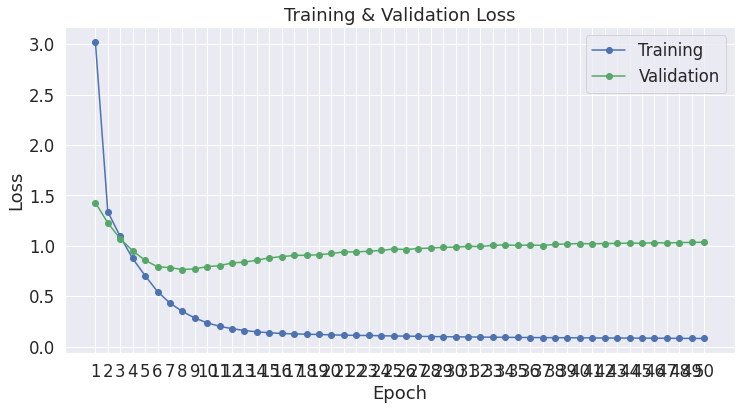

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
xt = [i for i in range(1,epochs+1)]
plt.xticks(xt)

plt.show()

In [17]:
import os
out_dir = '/NIPS'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained('./')
tokenizer.save_pretrained('./')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.json',
 './merges.txt',
 './added_tokens.json')

**Let's see how well our model performs**

In [18]:
model.eval()

prompt = "<|sos|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: I believe that if people stoped using or subscribing to @ATT they would be forced to make big changes at @CNN which is dying in the ratings anyway. It is so unfair with such bad Fake News! Why wouldn’t they act. When the World watches @CNN it gets a false picture of USA. Sad!


1: Lyin’ Brian Williams of MSDNC! https://t.co/3gtkdmoZjJ


2: The Fake News hates me saying that they are the Enemy of the People only because they know it’s TRUE. I am providing a great service by explaining this to the American People. They purposely cause great division & distrust. They can also cause War! They are very dangerous & sick!


3: The Wall Street Journal always “forgets” to mention that the ratings for the White House Press Briefings are “through the roof” (Monday Night Football, Bachelor Finale, according to @nytimes) & is only way for me to escape the Fake News & get my views across. WSJ is Fake News!


4: ....for the more traditional, but not very bright, Sleepy Joe Biden. Here we go again 

In [19]:
#Load Saved Model

model = GPT2LMHeadModel.from_pretrained('./')
tokenizer = GPT2Tokenizer.from_pretrained('./')
model.to(device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


**Let's use a tweet**

In [20]:
tweet_1 = 'dysfunctional and is so selfish he'

In [21]:
model.eval()

prompt = tweet_1

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: dysfunctional and is so selfish hedon’t have to sell himself to the bosses-big dollars ($700,000) for his wife’s political run from Hillary Clinton and her representatives. Dems are dumping Sleepy Joe. He’s coming home!


1: dysfunctional and is so selfish he can’t even get the Democrat Nomination. But he can’t get the questions asked of our great First Responders. Can’t get the questions asked of Sleepy Joe! https://t.co/CxQhObvL


2: dysfunctional and is so selfish hedon't even want to take off his mask! Phony @club4growth says I raised taxes—just another lie.


3: dysfunctional and is so selfish hedon’t have to live with his incompetent political bosses. Many others also
 need his Tax Cuts - He is badly under siege!


4: dysfunctional and is so selfish hedon’t have to pay exorbitant costs associated with NFL. Players take knee, raise taxes and then disrespecting our country! https://t.co/udXP5MR8BC




**References :**

* https://huggingface.co/blog/how-to-generate
* https://medium.com/analytics-vidhya/ai-writer-text-generation-using-gpt-2-transformers-4c33d8c52d5a